In [5]:
import sys
sys.path.append( '../cBot-Project/utilities' )
from data_engine import DataEngine
from backtesting import Backtesting
from custom_indicators import CustomIndocators as ci
import pandas as pd
import pandas_ta as pda
import ta
import ccxt
import json
f = open('../cBot-Project/database/pair_list.json',)
pairJson = json.load(f)
f.close()

In [6]:
pairList = pairJson['test']
timeframe = '1h'
startDate = '2021-12-01T00:00:00'

dataEngine = DataEngine(session=ccxt.binance())
# dataEngine = DataEngine(session=ccxt.ftx())

dfList = []
for pair in pairList:
    df = dataEngine.get_historical_from_db(pair, timeframe, startDate)
    #df = dataEngine.get_last_historical(symbol=pair, timeframe=timeframe, limit=1000)
    dfList.append(df)

print("Data load 100%")

../database/Binance/1h/VETUSDT.p not exist or error
../database/Binance/1h/DYDXUSDT.p not exist or error
../database/Binance/1h/GFTUSDT.p not exist or error
Data load 100%


In [7]:
# -- Indicator variable --
aoParam1 = 10   #6
aoParam2 = 22   #24
stochWindow = 14
willWindow = 14
atrWindow = 10
chopWindow = 14
ST_length = 14
ST_multiplier = 3.5

multi = [0.03, 0.06, 0.09]

# -- Drop all columns we do not need --
for df in dfList:
    # -- Drop all columns we do not need --
    df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)

    # -- Indicators, you can edit every value --
    df['SMA0'] = ta.trend.sma_indicator(close=df['close'], window=7)
    df['SMA1'] = df.apply(lambda df: df.SMA0 * (1 + multi[0]), axis=1)
    df['SMA2'] = df.apply(lambda df: df.SMA0 * (1 + multi[1]), axis=1)
    df['SMA3'] = df.apply(lambda df: df.SMA0 * (1 + multi[2]), axis=1)
    df['SMA_1'] = df.apply(lambda df: df.SMA0 * (1 - multi[0]), axis=1)
    df['SMA_2'] = df.apply(lambda df: df.SMA0 * (1 - multi[1]), axis=1)
    df['SMA_3'] = df.apply(lambda df: df.SMA0 * (1 - multi[2]), axis=1)

print("Indicators loaded 100%")

AttributeError: 'NoneType' object has no attribute 'drop'

In [96]:
dfTestList = []
for df in dfList:
    dfTestList.append(df.loc['2020-01-01':])

# -- Starting value --
startingBalance = 1000
makerFee = 0.0002*0.9
takerFee = 0.0002*0.9

# -- Rules --
StopLossActivation = False
takeProfitActivation = False
showLog = False

# -- Hyper parameters --
SlPct = 0.5
#TpPct = 0.10

multiATR = 0.3

maxPositions = 3
nLevel = 3

leverage = 1

# -- Trade Functions --

# -- Condition to BUY market --
def openLongCondition(row, previousRow=None, openLong=0):
    sma = previousRow[f'SMA_{openLong+1}']
    if (
        row['low'] <= sma
    ):
        return sma
    else:
        return 0

# -- Condition to SELL market --
def closeLongCondition(row, previousRow=None, prePreviousRow=None):
    sma = prePreviousRow['SMA0']
    if (
        previousRow['close'] >= sma
        or previousRow['high'] >= sma
    ):
        return sma
    else:
        return 0

def openShortCondition(row, previousRow=None, openShort=0):
    sma = previousRow[f'SMA{openShort+1}']
    if (
        row['high'] >= sma
    ):
        return sma
    else:
        return 0

# -- Condition to SELL market --
def closeShortCondition(row, previousRow=None, prePreviousRow=None):
    sma = prePreviousRow['SMA0']
    if (
        previousRow['close'] <= sma
        or previousRow['low'] <= sma
    ):
        return sma
    else:
        return 0

# -- Value initialisation --
usd = startingBalance
wallet = startingBalance
stopLoss = [0] * len(pairList)
takeProfit = [5000000] * len(pairList)
walletCoinArray = [0] * len(pairList)
walletUsdArray = [0] * len(pairList)
entryPrice = [0] * len(pairList)
leverageEnter = [1] * len(pairList)
position = ['LONG'] * len(pairList)
nPosition = [0] * len(pairList)
activePositions = 0
lastIndex = dfTestList[0].index.values[1]
lastLastIndex = dfTestList[0].index.values[1]

# -- Definition of dfTrades, that will be the dataset to do your trades analyses --
dfTrades = None
dfTrades = pd.DataFrame(columns=['date', 'symbol','position', 'reason',
                                 'price', 'frais', 'fiat', 'coins', 'wallet'])

for index, row in dfTestList[0].iterrows():
    # -- Check if you have one coin in your wallet --
    if (walletCoinArray.count(0) == len(walletCoinArray)) == False:
        # -- Iteration on all coin (upgrade possible: only check coin in your wallet) --
        for i in range(0,len(dfTestList)):
            """if(i==0):
                actualRow = dfTestList[i].loc[index]
                previousRow = dfTestList[i].loc[lastIndex]
                if(actualRow['SUPER_TREND_DIRECTION']>0):
                    leverageLong = 1
                    leverageShort = 1
                else:
                    leverageLong = 1
                    leverageShort = 1"""
            leverageLong = 1
            leverageShort = 1
            # -- Check if you have more than 0 coin --
            if walletCoinArray[i] != 0:
                try:
                    actualRow = dfTestList[i].loc[index]
                    previousRow = dfTestList[i].loc[lastIndex]
                    prePreviousRow = dfTestList[i].loc[lastLastIndex]

                    # -- Take Profit Long --
                    if (actualRow['high'] > takeProfit[i] and position[i]=='LONG' and takeProfitActivation==True):
                        nPosition[i] = 0
                        sellPrice = takeProfit[i]
                        usd = usd + walletCoinArray[i] * entryPrice[i] / leverageEnter[i] + walletCoinArray[i] * (sellPrice - entryPrice[i])
                        fee = makerFee * walletCoinArray[i] * sellPrice
                        usd = usd - fee
                        # -- Set coin and equivalent usd to 0 after sold position --
                        walletCoinArray[i] = 0
                        walletUsdArray[i] = 0
                        activePositions -= 1

                        # -- LOG --
                        if showLog:
                            print("Sell COIN at Take Profit", sellPrice, '$ the', index)

                        # -- Add the trade to dfTrades to analyse it later --
                        myrow = {
                            'date': index,
                            'symbol': pairList[i],
                            'position': "Sell",
                            'reason': 'Sell Take Profit',
                            'price': sellPrice,
                            'frais': fee,
                            'fiat': usd,
                            'coins': 0,
                            'wallet': sum(walletUsdArray) + usd
                        }
                        dfTrades = dfTrades._append(myrow, ignore_index=True)

                    # -- Take Profit Short --
                    elif (actualRow['low'] < takeProfit[i] and position[i]=='SHORT' and takeProfitActivation==True):
                        nPosition[i] = 0
                        sellPrice = takeProfit[i]
                        usd = usd + walletCoinArray[i] * entryPrice[i] / leverageEnter[i] + walletCoinArray[i] * (entryPrice[i] - sellPrice)
                        fee = makerFee * walletCoinArray[i] * sellPrice
                        usd = usd - fee
                        # -- Set coin and equivalent usd to 0 after sold position --
                        walletCoinArray[i] = 0
                        walletUsdArray[i] = 0
                        activePositions -= 1

                        # -- LOG --
                        if showLog:
                            print("Sell COIN at Take Profit", sellPrice, '$ the', index)

                        # -- Add the trade to dfTrades to analyse it later --
                        myrow = {
                            'date': index,
                            'symbol': pairList[i],
                            'position': "Sell",
                            'reason': 'Sell Take Profit',
                            'price': sellPrice,
                            'frais': fee,
                            'fiat': usd,
                            'coins': 0,
                            'wallet': sum(walletUsdArray) + usd
                        }
                        dfTrades = dfTrades._append(myrow, ignore_index=True)

                    # -- Sell Market --
                    elif (closeLongCondition(actualRow,previousRow, prePreviousRow) != 0 and position[i] == 'LONG'):
                        nPosition[i] = 0
                        sellPrice = closeLongCondition(actualRow,previousRow, prePreviousRow)
                        usd = usd + walletCoinArray[i] * entryPrice[i] / leverageEnter[i] + walletCoinArray[i] * (sellPrice - entryPrice[i])
                        fee = makerFee * walletCoinArray[i] * sellPrice
                        usd = usd - fee
                        # -- Set coin and equivalent usd to 0 after sold position --
                        walletCoinArray[i] = 0
                        walletUsdArray[i] = 0
                        activePositions -= 1

                        # -- LOG --
                        if showLog:
                            print("Sell", pairList[i],"at", sellPrice, '$ the', index)

                        # -- Add the trade to DfTrades to analyse it later --
                        myrow = {
                            'date': index,
                            'symbol': pairList[i],
                            'position': "Sell",
                            'reason': 'Sell Market Order',
                            'price': sellPrice,
                            'frais': fee,
                            'fiat': usd,
                            'coins': 0,
                            'wallet': sum(walletUsdArray) + usd
                        }
                        dfTrades = dfTrades._append(myrow, ignore_index=True)

                    # -- Sell Market --
                    elif (closeShortCondition(actualRow,previousRow,prePreviousRow) != 0 and position[i] == 'SHORT'):
                        nPosition[i] = 0
                        sellPrice = closeShortCondition(actualRow,previousRow,prePreviousRow)
                        usd = usd + walletCoinArray[i] * entryPrice[i] / leverageEnter[i] + walletCoinArray[i] * (entryPrice[i] - sellPrice)
                        fee = makerFee * walletCoinArray[i] * sellPrice
                        usd = usd - fee
                        # -- Set coin and equivalent usd to 0 after sold position --
                        walletCoinArray[i] = 0
                        walletUsdArray[i] = 0
                        activePositions -= 1

                        # -- LOG --
                        if showLog:
                            print("Sell", pairList[i],"at", sellPrice, '$ the', index)

                        # -- Add the trade to DfTrades to analyse it later --
                        myrow = {
                            'date': index,
                            'symbol': pairList[i],
                            'position': "Sell",
                            'reason': 'Sell Market Order',
                            'price': sellPrice,
                            'frais': fee,
                            'fiat': usd,
                            'coins': 0,
                            'wallet': sum(walletUsdArray) + usd
                        }
                        dfTrades = dfTrades._append(myrow, ignore_index=True)

                    """#adaptive leverage long
                    elif (leverageLong != leverageEnter[i] and position[i] == 'LONG'):
                        sellPrice = actualRow['close']
                        usd = usd + walletCoinArray[i] * entryPrice[i] / leverageEnter[i] + walletCoinArray[i] * (sellPrice - entryPrice[i])
                        fee = makerFee * walletCoinArray[i] * sellPrice
                        usd = usd - fee
                        # -- Set coin and equivalent usd to 0 after sold position --
                        walletCoinArray[i] = 0
                        walletUsdArray[i] = 0
                        activePositions -= 1

                        # -- LOG --
                        if showLog:
                            print("Sell", pairList[i],"at", sellPrice, '$ the', index)

                        # -- Add the trade to DfTrades to analyse it later --
                        myrow = {
                            'date': index,
                            'symbol': pairList[i],
                            'position': "Sell",
                            'reason': 'Sell Market Order',
                            'price': sellPrice,
                            'frais': fee,
                            'fiat': usd,
                            'coins': 0,
                            'wallet': sum(walletUsdArray) + usd
                        }
                        dfTrades = dfTrades.append(myrow, ignore_index=True)

                        buyPrice = actualRow['close']
                        # -- Define size of the position --
                        usdMultiplier = 1/(maxPositions-activePositions) * leverageLong
                        fee = takerFee * usd * usdMultiplier
                        usd = usd - fee
                        coin = (usd * usdMultiplier) / buyPrice
                        usd = usd - (usd * usdMultiplier / leverageLong)
                        leverageEnter[i] = leverageLong
                        entryPrice[i] = buyPrice
                        # -- Set coin and equivalent usd to size of position after open position --
                        walletCoinArray[i] = coin
                        walletUsdArray[i] = coin * actualRow['close'] / leverageLong
                        activePositions += 1
                        # -- Create a Stop Loss --
                        if StopLossActivation:
                            stopLoss[i] = buyPrice - SlPct * buyPrice
                        # -- Create a Take Profit --
                        if takeProfitActivation:
                            TpPct = actualRow['ATR']*multiATR
                            takeProfit[i] = buyPrice + TpPct

                        # -- LOG --
                        if showLog:
                            print("Buy", pairList[i],"at", buyPrice, '$ the', index)

                        # -- Add the trade to dfTrades to analyse it later --
                        myrow = {
                            'date': index,
                            'symbol': pairList[i],
                            'position': "Buy",
                            'reason': 'Buy Market Order',
                            'price': buyPrice,
                            'frais': fee,
                            'fiat': usd,
                            'coins': coin,
                            'wallet': sum(walletUsdArray) + usd
                        }
                        dfTrades = dfTrades.append(myrow, ignore_index=True)

                    #adaptive leverage short
                    elif (leverageShort != leverageEnter[i] and position[i] == 'SHORT'):
                        sellPrice = actualRow['close']
                        usd = usd + walletCoinArray[i] * entryPrice[i] / leverageEnter[i] + walletCoinArray[i] * (entryPrice[i] - sellPrice)
                        fee = makerFee * walletCoinArray[i] * sellPrice
                        usd = usd - fee
                        # -- Set coin and equivalent usd to 0 after sold position --
                        walletCoinArray[i] = 0
                        walletUsdArray[i] = 0
                        activePositions -= 1

                        # -- LOG --
                        if showLog:
                            print("Sell", pairList[i],"at", sellPrice, '$ the', index)

                        # -- Add the trade to DfTrades to analyse it later --
                        myrow = {
                            'date': index,
                            'symbol': pairList[i],
                            'position': "Sell",
                            'reason': 'Sell Market Order',
                            'price': sellPrice,
                            'frais': fee,
                            'fiat': usd,
                            'coins': 0,
                            'wallet': sum(walletUsdArray) + usd
                        }
                        dfTrades = dfTrades.append(myrow, ignore_index=True)

                        buyPrice = actualRow['close']
                        # -- Define size of the position --
                        usdMultiplier = 1/(maxPositions-activePositions) * leverageShort
                        fee = takerFee * usd * usdMultiplier
                        usd = usd - fee
                        coin = (usd * usdMultiplier) / buyPrice
                        usd = usd - (usd * usdMultiplier / leverageShort)
                        leverageEnter[i] = leverageShort
                        entryPrice[i] = buyPrice
                        # -- Set coin and equivalent usd to size of position after open position --
                        walletCoinArray[i] = coin
                        walletUsdArray[i] = coin * actualRow['close'] / leverageShort
                        activePositions += 1
                        # -- Create a Stop Loss --
                        if StopLossActivation:
                            stopLoss[i] = buyPrice + SlPct * buyPrice
                        # -- Create a Take Profit --
                        if takeProfitActivation:
                            TpPct = actualRow['ATR']*multiATR
                            takeProfit[i] = buyPrice - TpPct

                        # -- LOG --
                        if showLog:
                            print("Buy", pairList[i],"at", buyPrice, '$ the', index)

                        # -- Add the trade to dfTrades to analyse it later --
                        myrow = {
                            'date': index,
                            'symbol': pairList[i],
                            'position': "Buy",
                            'reason': 'Buy Market Order',
                            'price': buyPrice,
                            'frais': fee,
                            'fiat': usd,
                            'coins': coin,
                            'wallet': sum(walletUsdArray) + usd
                        }
                        dfTrades = dfTrades.append(myrow, ignore_index=True)

                    #adaptive takeProfit long
                    elif (takeProfit[i] > actualRow['close'] + actualRow['ATR']*multiATR and position[i] == 'LONG'):
                        takeProfit[i] = actualRow['close'] + actualRow['ATR']*multiATR

                    #adaptive takeProfit short
                    elif (takeProfit[i] < actualRow['close'] - actualRow['ATR']*multiATR and position[i] == 'SHORT'):
                        takeProfit[i] = actualRow['close'] - actualRow['ATR']*multiATR"""

                except Exception as e:
                    error = f"{type(e).__name__} at line {e.__traceback__.tb_lineno}: {e}"
    # -- Buy market order --
    # -- Check if you can open a new position --
    if activePositions < maxPositions:
        # -- Check buy condition for each coin of list --
        for i in range(0,len(dfTestList)):
            try:
                actualRow = dfTestList[i].loc[index]
                previousRow = dfTestList[i].loc[lastIndex]
                leverageLong = 1
                leverageShort = 1
                # -- Buy condition --
                buyPrice = openLongCondition(actualRow, previousRow)
                if (buyPrice != 0 and ((activePositions < maxPositions and nPosition[i] == 0) 
                             or (nPosition[i] != 0 and nPosition[i] < nLevel))):
                    #buyPrice = actualRow['close']
                    # -- Define size of the position --
                    usdMultiplier = 1/nLevel * 1/(maxPositions-activePositions) * leverageLong
                    fee = takerFee * usd * usdMultiplier
                    usd = usd - fee
                    coin = (usd * usdMultiplier) / buyPrice
                    usd = usd - (usd * usdMultiplier / leverageLong)
                    leverageEnter[i] = leverageLong
                    entryPrice[i] = (buyPrice + entryPrice[i]*nPosition[i])/(nPosition[i]+1)
                    position[i] = 'LONG'
                    # -- Set coin and equivalent usd to size of position after open position --
                    walletCoinArray[i] += coin
                    walletUsdArray[i] += coin * actualRow['close'] / leverageLong
                    if nPosition[i] == 0:
                        activePositions += 1
                    nPosition[i] += 1
                    # -- Create a Stop Loss --
                    if StopLossActivation:
                        stopLoss[i] = buyPrice - SlPct * buyPrice
                    # -- Create a Take Profit --
                    if takeProfitActivation:
                        TpPct = actualRow['ATR']*multiATR
                        takeProfit[i] = buyPrice + TpPct

                    # -- LOG --
                    if showLog:
                        print("Buy", pairList[i],"at", buyPrice, '$ the', index)

                    # -- Add the trade to dfTrades to analyse it later --
                    myrow = {
                        'date': index,
                        'symbol': pairList[i],
                        'position': "Buy Long",
                        'reason': 'Buy Market Order',
                        'price': buyPrice,
                        'frais': fee,
                        'fiat': usd,
                        'coins': coin,
                        'wallet': sum(walletUsdArray) + usd
                    }
                    dfTrades = dfTrades._append(myrow, ignore_index=True)

                elif(openShortCondition(actualRow, previousRow) != 0 
                        and ((activePositions < maxPositions and nPosition[i] == 0) 
                             or (nPosition[i] != 0 and nPosition[i] < nLevel))):
                    buyPrice = openShortCondition(actualRow, previousRow)
                    # -- Define size of the position --
                    usdMultiplier = 1/nLevel * 1/(maxPositions-activePositions) * leverageShort
                    fee = takerFee * usd * usdMultiplier
                    usd = usd - fee
                    coin = (usd * usdMultiplier) / buyPrice
                    usd = usd - (usd * usdMultiplier / leverageShort)
                    leverageEnter[i] = leverageShort
                    entryPrice[i] = (buyPrice + entryPrice[i]*nPosition[i])/(nPosition[i]+1)
                    position[i] = 'SHORT'
                    # -- Set coin and equivalent usd to size of position after open position --
                    walletCoinArray[i] += coin
                    walletUsdArray[i] += coin * actualRow['close'] / leverageShort
                    if nPosition[i] == 0:
                        activePositions += 1
                    nPosition[i] += 1
                    # -- Create a Stop Loss --
                    if StopLossActivation:
                        stopLoss[i] = buyPrice + SlPct * buyPrice
                    # -- Create a Take Profit --
                    if takeProfitActivation:
                        TpPct = actualRow['ATR']*multiATR
                        takeProfit[i] = buyPrice - TpPct

                    # -- LOG --
                    if showLog:
                        print("Buy", pairList[i],"at", buyPrice, '$ the', index)

                    # -- Add the trade to dfTrades to analyse it later --
                    myrow = {
                        'date': index,
                        'symbol': pairList[i],
                        'position': "Buy Short",
                        'reason': 'Buy Market Order',
                        'price': buyPrice,
                        'frais': fee,
                        'fiat': usd,
                        'coins': coin,
                        'wallet': sum(walletUsdArray) + usd
                    }
                    dfTrades = dfTrades._append(myrow, ignore_index=True)
            except Exception as e:
                error = f"{type(e).__name__} at line {e.__traceback__.tb_lineno}: {e}"

    # -- Keep last index to define last row --  
    lastLastIndex = lastIndex          
    lastIndex = index

print("Final wallet", sum(walletUsdArray) + usd)


Final wallet 22905.67552119941


In [97]:
dfTrades.iloc[-50:]

,date,symbol,position,reason,price,frais,fiat,coins,wallet
11240,2023-04-24 11:00:00,AUDIO/USDT,Buy Short,Buy Market Order,0.302305,0.563226,6257.687746,10349.957404,22350.980553
11241,2023-04-24 13:00:00,OMG/USDT,Sell,Sell Market Order,1.209857,1.797058,16505.868612,0.000000,22343.297263
11242,2023-04-24 13:00:00,AUDIO/USDT,Buy Short,Buy Market Order,0.305012,0.990352,11003.252173,18037.383304,22399.802359
11243,2023-04-24 14:00:00,AUDIO/USDT,Buy Short,Buy Market Order,0.307396,0.660195,7335.061319,11930.958617,22346.691965
11244,2023-04-24 15:00:00,OMG/USDT,Buy Long,Buy Market Order,1.185479,0.440104,4889.747477,2062.351693,22343.202527
11245,2023-04-24 17:00:00,AUDIO/USDT,Sell,Sell Market Order,0.301571,2.188592,17315.175472,0.000000,22411.816625
11246,2023-04-24 17:00:00,RAY/USDT,Buy Short,Buy Market Order,0.249922,1.038911,11542.757708,23092.707144,22278.637946
11247,2023-04-24 18:00:00,RAY/USDT,Sell,Sell Market Order,0.242643,1.008590,17481.226384,0.000000,22577.867538
11248,2023-04-24 19:00:00,AUDIO/USDT,Buy Short,Buy Market Order,0.313973,1.048874,11653.451674,18558.022134,22582.879184
11249,2023-04-24 21:00:00,OMG/USDT,Sell,Sell Market Order,1.180429,0.438203,14087.472333,0.000000,22575.075440


In [98]:
BTobject = Backtesting()
newDf = BTobject.multi_spot_backtest_analys(dfTrades=dfTrades, dfTest=dfTestList[0], pairList=pairList, timeframe=timeframe)

Trading Bot on : 46 coins | Timeframe : 1h
Period : [2021-12-01 00:00:00] -> [2023-04-29 08:00:00]
Starting balance : 998.8345730433639 $

----- General Informations -----
Final balance : 22905.68 $
Performance vs US Dollar : 2193.24 %
Bitcoin Buy and Hold Performence : -49.11 %
Performance vs Buy and Hold : 4406.14 %
Best trade : + 6.11 %, the 2022-03-23 08:00:00
Worst trade : -37.37 %, the 2022-03-18 14:00:00
Worst drawDown : - 52.2 %, the 2022-05-01 09:00:00
Total fees :  2165.61 $

----- Trades Informations -----
Total trades on period : 11289
Number of positive trades : 6714
Number of negative trades :  4575
Trades win rate absolute ratio : 59.47 %
Trades win rate ratio (without neutral) : 59.47 %
Average trades performance : 0.031 %
Average positive trades : 0.325 %
Average negative trades : -0.4 %
Gold number : 1.192
Sharpe Ratio : 0.766

----- Trades Reasons -----
reason
Buy Market Order     6270
Sell Market Order    5020
Name: count, dtype: int64

----- Pair Result -----
-----


----- Plot -----


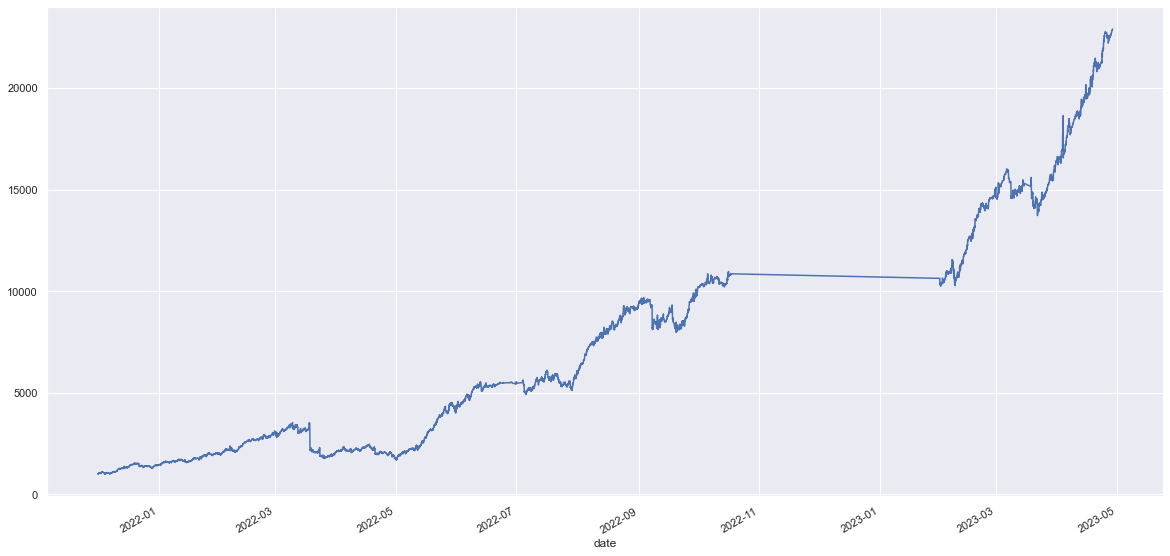

In [99]:
#BTobject.plot_wallet_evolution(dfTrades=newDf['2018'])
#BTobject.plot_wallet_evolution(dfTrades=newDf['2019'])
BTobject.plot_wallet_evolution(dfTrades)